# Biostat M280 Homework 3

**Due Friday, May 25 @ 11:59PM**

## Q1 - Big $n$ regression

Those who took my _203B: Introduction to Data Science_ last quarter had a (painful) experience of wrangling an Apache Spark cluster to do linear regression on a dataset with more than 100 million observations. Now we learnt various methods for solving linear regression and should realize that, with right choice of algorithm, it is a problem that can be handled by any moderate computer.

### Q1(1)

Download the flight data from <http://stat-computing.org/dataexpo/2009/the-data.html>. For this exercise, we only need data from years 2003-2008. If you are using Mac or Linux, you can run the following Bash script, which downloads and unzips files for all years.
```bash
# Download flight data by year
for i in {1987..2008}
  do
    echo "$(date) $i Download"
    fnam=$i.csv.bz2
    wget -O ./$fnam http://stat-computing.org/dataexpo/2009/$fnam
    echo "$(date) $i unzip"
    bzip2 -d ./$fnam
  done

# Download airline carrier data
wget -O ./airlines.csv http://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_UNIQUE_CARRIERS

# Download airports data
wget -O ./airports.csv https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
```
Find out how many data points in each year.

In [1]:
# how many data points
for i in 2003:2008
    file = "$i.csv"
    @show i
    @show countlines(file)
end

i = 2003
countlines(file) = 6488541
i = 2004
countlines(file) = 7129271
i = 2005
countlines(file) = 7140597
i = 2006
countlines(file) = 7141923
i = 2007
countlines(file) = 7453216
i = 2008
countlines(file) = 7009729


### Q1(2) 

We are interested in how the time gain of a flight, defined as `DepDelay - ArrDelay`, depends on the distance traveled (`Distance`), departure delay (`DepDelay`), and carrier (`UniqueCarrier`). 

We want to fit a linear regression `Gain ~ 1 + Distance + DepDelay + UniqueCarrier` using data from 2003-2008. Note `UniqueCarrier` is a factor with 23 levels: "9E", "AA", "AQ", "AS", "B6", "CO", "DH", "DL", "EV", "F9", "FL", "HA", "HP", "MQ", "NW", "OH", "OO", "TZ", "UA", "US", "WN", "XE", and "YV". We use the dummy coding with "9E" as base level.

Will the design matrix (in double precision) fit into the memory of you computer?

In [4]:
# mapping from variable names to X columns
# carrier "9E" is used as base level
const var2col = Dict(
        "Intercept" => 1,
        "Distance" => 2,
        "DepDelay" => 3,
        "AA" => 4,
        "AQ" => 5,
        "AS" => 6,
        "B6" => 7,
        "CO" => 8,
        "DH" => 9,
        "DL" => 10,
        "EV" => 11,
        "F9" => 12,
        "FL" => 13,
        "HA" => 14,
        "HP" => 15,
        "MQ" => 16,
        "NW" => 17,
        "OH" => 18,
        "OO" => 19,
        "TZ" => 20,
        "UA" => 21,
        "US" => 22,
        "WN" => 23,
        "XE" => 24,
        "YV" => 25,
        "Gain" => 26)
# mapping from column to variable names
const col2var = map(reverse, var2col)

# a custom function to generate [X y] from data table
function generate_xy(tbl)
    # X matrix
    XY = zeros(length(tbl), 26)
    # intercept term
    @views fill!(XY[:, 1], 1)
    # Distance term
    @views copy!(XY[:, 2], columns(tbl, :Distance))
    # DepDelay term
    @views copy!(XY[:, 3], columns(tbl, :DepDelay))
    # Dummy coding for airline
    @inbounds for i in 1:length(tbl)
        tbl[i][:UniqueCarrier] == "9E" && continue # base level
        XY[i, var2col[tbl[i][:UniqueCarrier]]] = 1
    end
    # last column is response: gain = depdelay - arrdelay
    XY[:, 26] = select(tbl, 
        (:DepDelay, :ArrDelay) => p -> Float64(p.DepDelay - p.ArrDelay))
    # return
    XY
end

generate_xy (generic function with 1 method)

* The whole data will occupy too much memory. 

### Q1(3)

Review the [Summary of Linear Regression](http://hua-zhou.github.io/teaching/biostatm280-2018spring/slides/12-linreg/linreg.html) and devise a strategy to solve the linear regression.

Report the estimated regression coefficients $\widehat \beta$, estimated variance $\widehat \sigma^2 = \sum_i (y_i - \widehat y_i)^2 / (n - 1)$, and coefficient standard errors.

Hint: It took my laptop less than 3 minutes to import data and fit linear regression.

In [5]:
#Pkg.add("JuliaDB")
using JuliaDB
using SweepOperator
function sumXy(year1, year2)
    sumxx = zeros(25, 25)
    sumxy = zeros(25, 1)
    sumyy = 0
    for i in year1: year2
        file = "$i.csv"
        yrtable = loadtable(
            file, 
        datacols = ["DepDelay", "ArrDelay", "UniqueCarrier", "Distance"])
        yrtable = dropna(yrtable)
        xy = generate_xy(yrtable)
        X = xy[:, 1:25]
        y = xy[:, 26]
        x_x = At_mul_B(X, X)
        x_y = At_mul_B(X, y)
        y_y = At_mul_B(y, y)
        sumxx = sumxx + x_x
        sumxy = sumxy + x_y
        sumyy = sumyy + y_y        
    end
    G = [sumxx sumxy; sumxy' sumyy]
    tableau = sweep!(G, 1:25)
    return tableau[1:25, end]
end

sumXy (generic function with 1 method)

In [6]:
@time sweepmatrix = sumXy(2003, 2008)

498.697234 seconds (494.17 M allocations: 55.035 GiB, 14.40% gc time)


25-element Array{Float64,1}:
  1.14033   
  0.00164935
 -0.0118811 
 -1.8723    
 -0.5789    
 -0.938452  
 -1.42247   
 -2.57627   
  1.16808   
 -2.19625   
  1.03932   
 -2.15207   
 -1.35247   
 -1.87248   
 -0.350758  
 -1.46395   
 -3.62506   
 -0.00722279
 -0.40365   
 -3.5774    
 -1.14816   
 -0.883753  
  2.74855   
 -2.56721   
 -0.202211  

* Another method: 

In [7]:
using JuliaDB
using SweepOperator
function sumXy1(year1, year2)
    sumxx = zeros(25, 25)
    sumxy = zeros(25, 1)
    sumyy = 0
    for i in year1: year2
        file = "$i.csv"
        yrtable = loadtable(
            file, 
        datacols = ["DepDelay", "ArrDelay", "UniqueCarrier", "Distance"])
        yrtable = dropna(yrtable)
        xy = generate_xy(yrtable)
        X = xy[:, 1:25]
        y = xy[:, 26]
        x_x = At_mul_B(X, X)
        x_y = At_mul_B(X, y)
        y_y = At_mul_B(y, y)
        sumxx = sumxx + x_x
        sumxy = sumxy + x_y
        sumyy = sumyy + y_y        
    end
    beta = inv(sumxx) * sumxy
    return sumxx, sumxy, sumyy, beta
end

sumXy1 (generic function with 1 method)

In [8]:
@time sumxx, sumxy, sumyy, beta = sumXy1(2003, 2008)

524.482487 seconds (481.32 M allocations: 54.208 GiB, 17.13% gc time)


([4.14904e7 3.00028e10 … 2.29046e6 822290.0; 3.00028e10 3.51353e13 … 1.23256e9 3.27927e8; … ; 2.29046e6 1.23256e9 … 2.29046e6 0.0; 822290.0 3.27927e8 … 0.0 822290.0], [6.0236e7; 5.75882e10; … ; -1.46404e6; 1.18638e6], 8.723124423e9, [1.14033; 0.00164935; … ; -2.56721; -0.202211])

In [9]:
inv(sumxx) * sumxy

25×1 Array{Float64,2}:
  1.14033   
  0.00164935
 -0.0118811 
 -1.8723    
 -0.5789    
 -0.938452  
 -1.42247   
 -2.57627   
  1.16808   
 -2.19625   
  1.03932   
 -2.15207   
 -1.35247   
 -1.87248   
 -0.350758  
 -1.46395   
 -3.62506   
 -0.00722279
 -0.40365   
 -3.5774    
 -1.14816   
 -0.883753  
  2.74855   
 -2.56721   
 -0.202211  

* The results of beta are same.

### Q1(4)

Go to your resume/cv and claim you have experience performing analytics on data with hundred millions of observations.

* Done :)

### Sample code

Following code explores the data in 2003 and generates the design matrix and responses for that year. Feel free to use the code in your solution.

In [1]:
;head 2003.csv

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2003,1,29,3,1651,1655,1912,1913,UA,1017,N202UA,141,138,119,-1,-4,ORD,MSY,837,5,17,0,NA,0,NA,NA,NA,NA,NA
2003,1,30,4,1654,1655,1910,1913,UA,1017,N311UA,136,138,108,-3,-1,ORD,MSY,837,2,26,0,NA,0,NA,NA,NA,NA,NA
2003,1,31,5,1724,1655,1936,1913,UA,1017,N317UA,132,138,110,23,29,ORD,MSY,837,5,17,0,NA,0,NA,NA,NA,NA,NA
2003,1,1,3,1033,1035,1625,1634,UA,1018,N409UA,232,239,215,-9,-2,OAK,ORD,1835,6,11,0,NA,0,NA,NA,NA,NA,NA
2003,1,2,4,1053,1035,1726,1634,UA,1018,N496UA,273,239,214,52,18,OAK,ORD,1835,13,46,0,NA,0,NA,NA,NA,NA,NA
2003,1,3,5,1031,1035,1640,1634,UA,1018,N412UA,249,239,223,6,-4,OAK,ORD,1835,13,13,0,NA,0,NA,NA,NA,NA,NA
2003,1,4,6,1031,1035,1626,1634,UA,1018,N455UA,235,239,219,-8,-4,OAK,ORD,183

In [2]:
# how many data points
countlines("2003.csv")

6488541

In [3]:
# import data from csv
using JuliaDB
# only need columns: DepDelay, ArrDelay, UniqueCarrier, Distance
@time yrtable = loadtable(
    "2003.csv", 
    datacols = ["DepDelay", "ArrDelay", "UniqueCarrier", "Distance"])

 47.277701 seconds (153.71 M allocations: 8.170 GiB, 27.08% gc time)


Table with 6488540 rows, 4 columns:
DepDelay  ArrDelay  UniqueCarrier  Distance
───────────────────────────────────────────
-4        -1        "UA"           837
-1        -3        "UA"           837
29        23        "UA"           837
-2        -9        "UA"           1835
18        52        "UA"           1835
-4        6         "UA"           1835
-4        -8        "UA"           1835
0         2         "UA"           1835
-4        19        "UA"           1835
3         4         "UA"           413
-4        -23       "UA"           413
-3        -19       "UA"           413
⋮
#NA       #NA       "DL"           1891
29        62        "DL"           581
39        66        "DL"           1891
26        27        "DL"           1678
114       134       "DL"           946
44        53        "DL"           813
16        47        "DL"           432
50        54        "DL"           432
-3        -5        "DL"           453
3         3         "DL"           689
-1     

In [4]:
# drop rows with missing values
yrtable = dropna(yrtable)

Table with 6375689 rows, 4 columns:
DepDelay  ArrDelay  UniqueCarrier  Distance
───────────────────────────────────────────
-4        -1        "UA"           837
-1        -3        "UA"           837
29        23        "UA"           837
-2        -9        "UA"           1835
18        52        "UA"           1835
-4        6         "UA"           1835
-4        -8        "UA"           1835
0         2         "UA"           1835
-4        19        "UA"           1835
3         4         "UA"           413
-4        -23       "UA"           413
-3        -19       "UA"           413
⋮
70        66        "DL"           1891
29        62        "DL"           581
39        66        "DL"           1891
26        27        "DL"           1678
114       134       "DL"           946
44        53        "DL"           813
16        47        "DL"           432
50        54        "DL"           432
-3        -5        "DL"           453
3         3         "DL"           689
-1     

In [26]:
# mapping from variable names to X columns
# carrier "9E" is used as base level
const var2col = Dict(
        "Intercept" => 1,
        "Distance" => 2,
        "DepDelay" => 3,
        "AA" => 4,
        "AQ" => 5,
        "AS" => 6,
        "B6" => 7,
        "CO" => 8,
        "DH" => 9,
        "DL" => 10,
        "EV" => 11,
        "F9" => 12,
        "FL" => 13,
        "HA" => 14,
        "HP" => 15,
        "MQ" => 16,
        "NW" => 17,
        "OH" => 18,
        "OO" => 19,
        "TZ" => 20,
        "UA" => 21,
        "US" => 22,
        "WN" => 23,
        "XE" => 24,
        "YV" => 25,
        "Gain" => 26)
# mapping from column to variable names
const col2var = map(reverse, var2col)

# a custom function to generate [X y] from data table
function generate_xy(tbl::NextTable)
    # X matrix
    XY = zeros(length(tbl), 26)
    # intercept term
    @views fill!(XY[:, 1], 1)
    # Distance term
    @views copy!(XY[:, 2], columns(tbl, :Distance))
    # DepDelay term
    @views copy!(XY[:, 3], columns(tbl, :DepDelay))
    # Dummy coding for airline
    @inbounds for i in 1:length(tbl)
        yrtable[i][:UniqueCarrier] == "9E" && continue # base level
        XY[i, var2col[tbl[i][:UniqueCarrier]]] = 1
    end
    # last column is response: gain = depdelay - arrdelay
    XY[:, 26] = select(tbl, 
        (:DepDelay, :ArrDelay) => p -> Float64(p.DepDelay - p.ArrDelay))
    # return
    XY
end

generate_xy (generic function with 1 method)

In [27]:
@time xy = generate_xy(yrtable)

  9.347537 seconds (19.18 M allocations: 1.950 GiB, 14.88% gc time)


6375689×26 Array{Float64,2}:
 1.0   837.0   -4.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  0.0  0.0   -3.0
 1.0   837.0   -1.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0    2.0
 1.0   837.0   29.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0    6.0
 1.0  1835.0   -2.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0    7.0
 1.0  1835.0   18.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  -34.0
 1.0  1835.0   -4.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  0.0  0.0  -10.0
 1.0  1835.0   -4.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0    4.0
 1.0  1835.0    0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0   -2.0
 1.0  1835.0   -4.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  -23.0
 1.0   413.0    3.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0   -1.0
 1.0   413.0   -4.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  0.0  0.0   19.0
 1.0   413.0   -3.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0   16.0
 1.0   413.0    0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0   1

## Q2 - Google PageRank

We are going to try different numerical methods learnt in class on the [Google PageRank problem](https://en.wikipedia.org/wiki/PageRank).

### Q2(1)

Let $\mathbf{A} \in \{0,1\}^{n \times n}$ be the connectivity matrix of $n$ web pages with entries
$$
\begin{eqnarray*}
	a_{ij}= \begin{cases}
	1 & \text{if page $i$ links to page $j$} \\
	0 & \text{otherwise}
	\end{cases}.
\end{eqnarray*}
$$
$r_i = \sum_j a_{ij}$ is the out-degree of page $i$. That is $r_i$ is the number of links on page $i$. Imagine a random surfer exploring the space of $n$ pages according to the following rules.  

- From a page $i$ with $r_i>0$
    * with probability $p$, (s)he randomly chooses a link on page $i$ (uniformly) and follows that link to the next page  
    * with probability $1-p$, (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
- From a page $i$ with $r_i=0$ (a dangling page), (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
    
The process defines a Markov chain on the space of $n$ pages. Write the transition matrix $\mathbf{P}$ of the Markov chain as a sparse matrix plus rank 1 matrix.

#### Q2 (1) Answer: 

For a page $i$ with $r_i>0$ (there are $r_i$ links),
- if there is link between page i and page j, then $p_{ij} = p a_{ij} / r_i $.
- if there is no link between page i and page j, then $p_{ij} = (1-p) / n  $.

For a page $i$ with $r_i=0$ (there is no link), 
- the probability will be probability that randomly select a page from $\mathbf{n}$ pages, then $p_{ij} = 1 / n  $.

Therefore, 
$$ p_{ij} = \begin{cases} p a_{ij} / r_i + (1-p) / n & r_i > 0 \\ 1/n & r_i = 0 \end{cases}. $$ 

To write the transition matrix $\mathbf{P}$,

Let $$ r_i^* = \begin{cases} p/r_i & r_i > 0 \\ 0 & r_i = 0 \end{cases} $$

and let $\mathbf{z} \in \mathbf{R}^n$ has entries $$ z_i = \begin{cases} (1-p)/n & r_i > 0 \\ 1/n & r_i = 0 \end{cases}. $$

Then the transition matrix $\mathbf{P}$ can be written as:
$$ \mathbf{P} = \text{diag}(\mathbf{r}^*) * \mathbf{A} + \mathbf{z} \mathbf{1}_n^T, $$ 

### Q2(2)

According to standard Markov chain theory, the (random) position of the surfer converges to the stationary distribution $\mathbf{x} = (x_1,\ldots,x_n)^T$ of the Markov chain. $x_i$ has the natural interpretation of the proportion of times the surfer visits page $i$ in the long run. Therefore $\mathbf{x}$ serves as page ranks: a higher $x_i$ means page $i$ is more visited. It is well-known that $\mathbf{x}$ is the left eigenvector corresponding to the top eigenvalue 1 of the transition matrix $\mathbf{P}$. That is $\mathbf{P}^T \mathbf{x} = \mathbf{x}$. Therefore $\mathbf{x}$ can be solved as an eigen-problem. Show that it can also be cast as solving a linear system. Since the row sums of $\mathbf{P}$ are 1, $\mathbf{P}$ is rank deficient. We can replace the first equation by the $\sum_{i=1}^n x_i = 1$.

### Q2(3)

Download the [`ucla.zip`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw3/ucla.zip) package from course webpage. Unzip the package, which contains two files `U.txt` and `A.txt`. `U.txt` lists the 500 URL names. `A.txt` is the $500 \times 500$ connectivity matrix. Read data into Julia. Compute summary statistics:
* number of pages
* number of edges
* number of dangling nodes (pages with no out links)
* which page has max in-degree?
* which page has max out-degree?
* visualize the sparsity pattern of $\mathbf{A}$

In [12]:
# Read in A.txt
A = readcsv("ucla/A.txt")
# sparse matrix
A = sparse(A)
U = vec(readdlm("ucla/U.txt", '\n', String))

500-element Array{String,1}:
 "http://www.ucla.edu"                                                                                                                     
 "http://4393665.fls.doubleclick.net/activityi;src=4393665;type=Prima0;cat=UCLAe0;ord="                                                    
 "http://www.atmos.ucla.edu/weather/quick-look"                                                                                            
 "http://bit.ly/10Wf0Te"                                                                                                                   
 "http://bit.ly/1NMd3KF"                                                                                                                   
 "http://bit.ly/1JTGEHi"                                                                                                                   
 "http://bit.ly/1JTGEHj"                                                                                                           

In [13]:
# pages
n = size(A, 1)

500

In [14]:
# edges
countnz(A)

11158

In [15]:
# dangling nodes (pages with no out links)?
outdeg = sum(A, 2)
countnz(outdeg .< 1)

96

In [16]:
# page has max in-degree?
indeg = sum(A, 1)
idxideg = indmax(indeg)
@show U[idxideg]
@show indeg[idxideg]

U[idxideg] = "http://www.ucla.edu"
indeg[idxideg] = 171.0


171.0

In [17]:
# page has max out-degree?
idxodeg = indmax(outdeg)
@show U[idxodeg]
@show outdeg[idxodeg];

U[idxodeg] = "http://giveto.ucla.edu"
outdeg[idxodeg] = 88.0


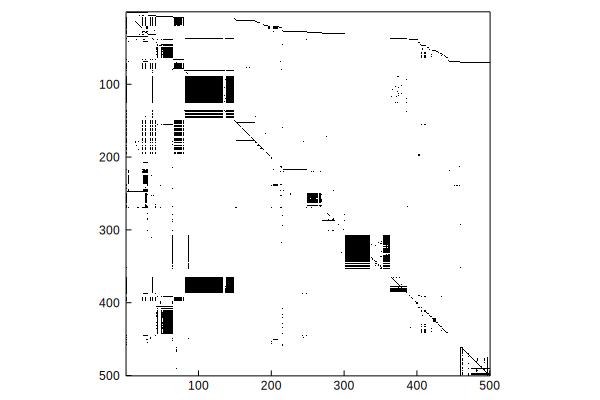

In [19]:
#Pkg.add("GR")
using Plots, GR
#plotly()
gr()
spy(A)

### Q2(4)

Set the _teleportation_ parameter at $p = 0.85$. Try the following methods to solve for $\mathbf{x}$ using the `ucla.zip` data.

0. A dense linear system solver such as LU decomposition.  
0. A simple iterative linear system solver such as Jacobi or Gauss-Seidel.   
0. A dense eigen-solver.  
0. A simple iterative eigen-solver such as the power method.  

For iterative methods, you can use the [`IterativeSolvers.jl`](https://github.com/JuliaMath/IterativeSolvers.jl) package. Make sure to utilize the special structure of $\mathbf{P}$ (sparse + rank 1) to speed up the matrix-vector multiplication.

In [20]:
p = 0.85;

In [21]:
function pagerank_lu(A::AbstractMatrix, p::Float64 = 0.85)
    
    n = size(A, 1)
    # r and z vectors
    outdeginv = vec(sum(A, 2))
    z = zeros(outdeginv)
    fill!(z, 1 / n)
    for i in 1:n
        if outdeginv[i] > 0
            outdeginv[i] = p / outdeginv[i]
            z[i] = (1 - p) / n
        end
    end
    # P = outdeginv * A .+ z
    # prepare the linear system I - P^t
    M = I - full(A') * Diagonal(outdeginv) .- z'
    # replace the first equation by the sum-to-1 constraint
    M[1, :] = 1.0
    # LU solve with right hand side e_1
    b = zeros(n)
    b[1] = 1.0
    return M \ b
    
end

pagerank_lu (generic function with 2 methods)

In [22]:
@time uclapgrk_lu = pagerank_lu(A)

  2.338304 seconds (500.87 k allocations: 34.027 MiB, 0.80% gc time)


500-element Array{Float64,1}:
 0.0115263 
 0.00118521
 0.00368196
 0.00361842
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00137118
 0.00133263
 ⋮         
 0.00136037
 0.00136037
 0.00129072
 0.00337188
 0.00215239
 0.00136037
 0.00136037
 0.00750605
 0.00136037
 0.00136037
 0.00136037
 0.00107129

In [23]:
topidx = sortperm(uclapgrk_lu, rev=true)[1:20]
[collect(1:20) uclapgrk_lu[topidx] U[topidx]]

20×3 Array{Any,2}:
  1  …  "http://hammer.ucla.edu"                                                                
  2     "http://schema.org"                                                                     
  3     "http://www"                                                                            
  4     "http://giveto.ucla.edu/comments/feed"                                                  
  5     "http://browsehappy.com"                                                                
  6  …  "http://schema.org/Text"                                                                
  7     "http://www.ucla.edu"                                                                   
  8     "http://www.directory.ucla.edu"                                                         
  9     "http://www.universityofcalifornia.edu"                                                 
 10     "http://schema.org/CreativeWork"                                                        
 11  …  "ht

### Q2(5)

List the top 20 ranked URLs you found.

### Q2(6)

As of Monday May 11 2018, there are at least 1.83 billion indexed webpages on internet according to <http://www.worldwidewebsize.com/>. Explain whether each of these methods works for the PageRank problem at this scale.